# Application of Undersampling in Predicting Forest Cover Type using Classification Models in an Imbalanced Data
Raphael E. Gutierrez • August 7, 2021

Using different supervised classification methods, this notebook aims to predict forest cover type from cartographic variables. The Covertype Dataset is multivariate and contains 581,012 instances of 55 features, a mix of integer and categorical (binary) data. The categorical features (Soil Types and Wilderness Areas) are already converted into binary data to represent as numerical format. The Cover_Type feature highlights an imbalanced distribution of the classes. Due to the large size of the dataset, undersampling is used instead of oversampling to randomly sample the data. Undersampling is a random sampling technique used to randomly remove samples from the majority class. The dataset was retrieved from https://archive.ics.uci.edu/ml/datasets/Covertype.

## Getting Started
This section imports all the necessary packages for this notebook. Header names are also added to the DataFrame.

**NOTE**: To avoid getting any sklearn error, particularly when training a Logistic Regression model using liblinear solver, a scikit-learn version 0.24.x or higher must be used.

In [5]:
# Libraries for linear algebra and DataFrame processing
import numpy as np
import pandas as pd

# Libraries for colormap and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Functions for feature scaling, splitting, metrics, and tuning hyperparameters
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV

# Classification models 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
# Reading the file and adding header names

soil_types = ["Soil_Type_" + str(i) for i in range(1, 40+1)]
wilderness_areas = ["Wilderness_Area_" + str(i) for i in range(1, 4+1)]
header_names = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", 
                "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
                "Horizontal_Distance_To_Fire_Points"] + soil_types + wilderness_areas + ["Cover_Type"]

data = pd.read_csv("../input/covtype/covtype.data", names=header_names, header=None)

In [7]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [10]:
data.shape

(581012, 55)

# Data Preprocessing
All data points in the dataset are checked for Null/NaN values. data.dropna() will be used in case of an instance that the dataset has Null/NaN data points.

In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Soil_Type_1                         581012 non-null  int64
 11  Soil_Type_2                         581012 non-null 

In [12]:
print("Features have Null and/or NaN values:", data.isnull().values.any())
print(data.isnull().sum())
# data = data.dropna()

Features have Null and/or NaN values: False
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Soil_Type_1                           0
Soil_Type_2                           0
Soil_Type_3                           0
Soil_Type_4                           0
Soil_Type_5                           0
Soil_Type_6                           0
Soil_Type_7                           0
Soil_Type_8                           0
Soil_Type_9                           0
Soil_Type_10                          0
Soil_Type_11                          0
Soil_Type_12                          0
Soil_Type_13                          0
Soil_Type_14                        

## Class Distribution & Plotting
Visualization of two of the features (Elevation and Aspect) and the huge imbalanced distribution of the Cover_Type feature.

In [13]:
data["Cover_Type"].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

Text(0.5, 1.0, 'Elevation vs. Aspect')

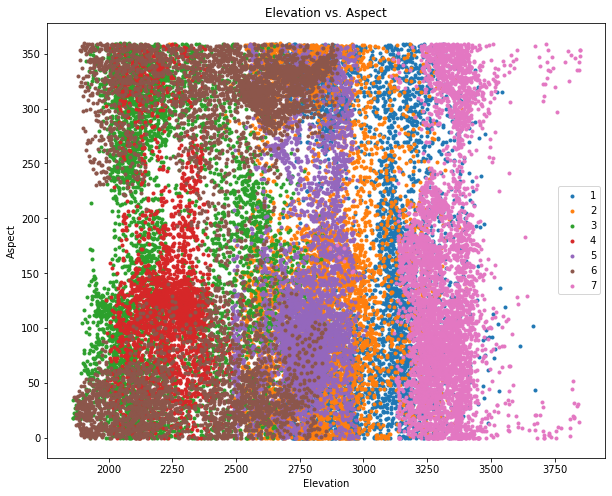

In [14]:
plt.figure(figsize=(10,8))

for i in range(1,7+1):
    X = data[data["Cover_Type"] == i]["Elevation"][:5000]
    y = data[data["Cover_Type"] == i]["Aspect"][:5000]
    plt.scatter(X, y, marker=".", label=i)
    
plt.legend(loc="best")
plt.xlabel("Elevation")
plt.ylabel("Aspect")
plt.title("Elevation vs. Aspect")

Text(0.5, 1.0, 'Class Distribution of Cover_Type')

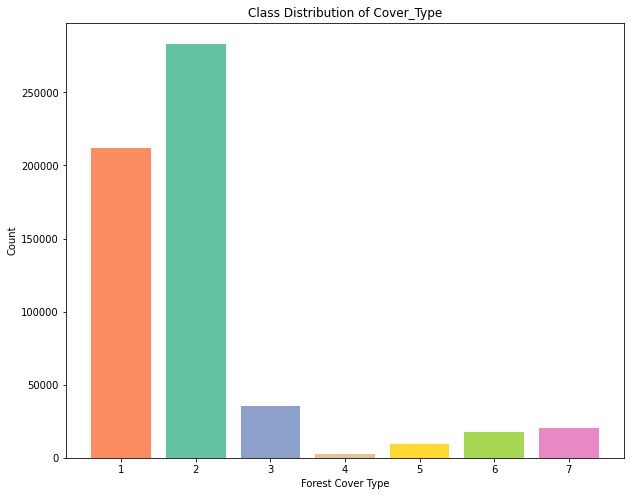

In [15]:
cmap = sns.color_palette("Set2", as_cmap=True)
cmap = cmap(np.arange(7))

plt.figure(figsize=(10,8))
plt.bar(height=data["Cover_Type"].value_counts().values, x=data["Cover_Type"].value_counts().keys(), color=cmap)
plt.xlabel("Forest Cover Type")
plt.ylabel("Count")
plt.title("Class Distribution of Cover_Type")

# Random sampling method is used because classes have huge differences 

## Helper Functions
split_scale - Splits the dataset into training and testing sets then scaled using StandardScaler().

evaluate_model - Evaluates the model using mean accuracy (score), confusion matrix in a heatmap, and classification report.

In [109]:
def split_scale(data):
    df = data.copy()

    X = df.drop("Cover_Type", axis=1).copy()
    y = df["Cover_Type"].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # Divides DataFrame into continuous and binary columns (reset_index, see documentation). Continuous columns will be scaled
    X_train_nobinary = X_train.loc[:, :"Horizontal_Distance_To_Fire_Points"]
    X_train_binary = X_train.reset_index(drop=True).loc[:, "Soil_Type_1":]

    X_test_binary = X_test.reset_index(drop=True).loc[:, "Soil_Type_1":]
    X_test_nobinary = X_test.loc[:, :"Horizontal_Distance_To_Fire_Points"]

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train_nobinary)
    X_train_df = pd.DataFrame(X_train_scaled, columns=X_train_nobinary.columns)

    X_test_scaled = scaler.fit_transform(X_test_nobinary)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X_test_nobinary.columns)

    # Concatenates scaled DF (no binary) and DF with binary features 
    X_train = pd.concat([X_train_df, X_train_binary], axis=1)
    X_test = pd.concat([X_test_df, X_test_binary], axis=1)

    return X_train, X_test, y_train, y_test

In [110]:
def evaluate_model(model, X_test, y_test):
    score = model.score(X_test, y_test)
    print("Accuracy: %.2f" % score)
    
    y_pred = model.predict(X_test)
    
    cmatrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8,8))
    sns.heatmap(cmatrix, annot=True, fmt="g", vmin=0, cmap="Blues", 
                xticklabels=np.sort(y_test.unique()), yticklabels=np.sort(y_test.unique()))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    print(classification_report(y_test, y_pred))

## Model Application & Evaluation (Imbalanced Data)
Due to hardware limitations, Logistic Regression and Naive Bayes are used. Notice that these models can handle large dataset (not yet undersampled) faster than other approaches.

In [128]:
X_train, X_test, y_train, y_test = split_scale(data)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (406708, 54)
X_test shape: (174304, 54)
y_train shape: (406708,)
y_test shape: (174304,)


### Logistic Regression

In [129]:
%%time

logreg1 = LogisticRegression()
logreg1.fit(X_train, y_train)

CPU times: user 1min 11s, sys: 30.1 s, total: 1min 41s
Wall time: 35.5 s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

Accuracy: 0.72
              precision    recall  f1-score   support

           1       0.71      0.70      0.70     63498
           2       0.75      0.80      0.77     85198
           3       0.67      0.82      0.74     10581
           4       0.64      0.43      0.52       822
           5       0.12      0.00      0.01      2850
           6       0.48      0.24      0.32      5229
           7       0.73      0.58      0.64      6126

    accuracy                           0.72    174304
   macro avg       0.59      0.51      0.53    174304
weighted avg       0.71      0.72      0.71    174304



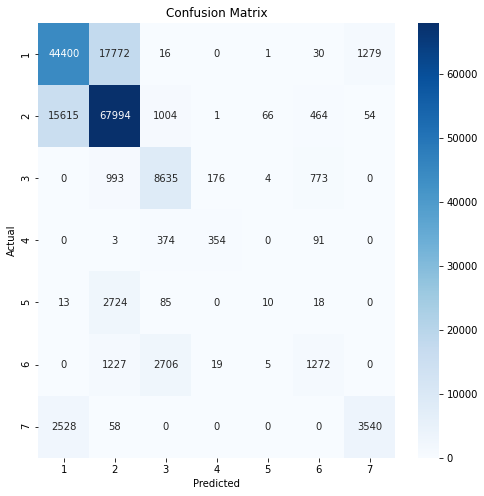

In [130]:
evaluate_model(logreg1, X_test, y_test)

### Naive Bayes

In [131]:
%%time

nb1 = GaussianNB()
nb1.fit(X_train, y_train)

CPU times: user 417 ms, sys: 123 ms, total: 540 ms
Wall time: 538 ms


GaussianNB()

Accuracy: 0.09
              precision    recall  f1-score   support

           1       0.18      0.03      0.05     63498
           2       0.86      0.02      0.03     85198
           3       0.29      0.40      0.34     10581
           4       0.08      1.00      0.14       822
           5       0.02      0.73      0.05      2850
           6       0.16      0.08      0.11      5229
           7       0.11      0.95      0.20      6126

    accuracy                           0.09    174304
   macro avg       0.24      0.46      0.13    174304
weighted avg       0.51      0.09      0.07    174304



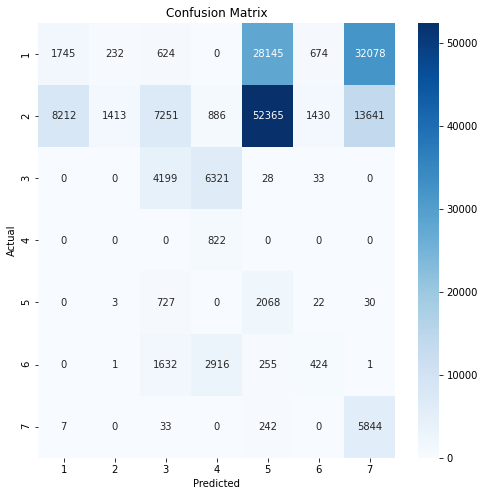

In [132]:
evaluate_model(nb1, X_test, y_test)

## Model Application & Evaluation (Undersampled Data)
In this section, Logistic Regression, Naive Bayes, Decision Tree Classifier, and Random Forest Classifier are used to predict the forest cover types in an undersampled data.

### Undersampling the Data
Undersampling, a random sampling technique, is used to randomly remove samples from the majority class. This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset. Undersampling process can be repeated until the desired class distribution is achieved, such as an equal number of examples for each class.

In [133]:
# Undersampling

undersampled_raw = data.copy()

min_class_size = np.min(undersampled_raw["Cover_Type"].value_counts().values)

class_subsets = [undersampled_raw.query("Cover_Type == "+ str(i+1)) for i in range(7)]

for i in range(7):
    class_subsets[i] = class_subsets[i].sample(min_class_size, random_state=0)
    
undersampled_data = pd.concat(class_subsets, axis=0).sample(frac=1.0, random_state=0)
undersampled_data = undersampled_data.reset_index(drop=True)

In [134]:
undersampled_data["Cover_Type"].value_counts()

1    2747
2    2747
3    2747
4    2747
5    2747
6    2747
7    2747
Name: Cover_Type, dtype: int64

In [135]:
X_train, X_test, y_train, y_test = split_scale(undersampled_data)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (13460, 54)
X_test shape: (5769, 54)
y_train shape: (13460,)
y_test shape: (5769,)


### Logistic Regression

In [136]:
# liblinear is dropped since it is slow for large datasets
# Notice that all solvers only handles L2 regularization

logreg_param_grid = {"solver": ["newton-cg", "lbfgs", "sag", "saga"], 
                     "C": [10, 1, 0.1, 0.01]}

In [137]:
# n_iter value should be smaller or equal to the multiplied value of all parameters

rs_logreg = RandomizedSearchCV(LogisticRegression(), logreg_param_grid, n_iter=50,
                               cv=5, verbose=1, random_state=0)
rs_logreg.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=50,
                   param_distributions={'C': [10, 1, 0.1, 0.01],
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga']},
                   random_state=0, verbose=1)

In [138]:
print("Test set score: %.2f" % rs_logreg.score(X_test, y_test))
print("Best cross-validation score: %.2f" % rs_logreg.best_score_)
print("Best parameters:", rs_logreg.best_params_)
print("Best estimator:", rs_logreg.best_estimator_)

Test set score: 0.71
Best cross-validation score: 0.71
Best parameters: {'solver': 'newton-cg', 'C': 10}
Best estimator: LogisticRegression(C=10, solver='newton-cg')


In [140]:
%%time

logreg2 = LogisticRegression(solver="newton-cg", C=10)
logreg2.fit(X_train, y_train)

CPU times: user 18.8 s, sys: 8.79 s, total: 27.6 s
Wall time: 6.97 s


LogisticRegression(C=10, solver='newton-cg')

Accuracy: 0.71
              precision    recall  f1-score   support

           1       0.68      0.66      0.67       846
           2       0.62      0.54      0.58       817
           3       0.62      0.54      0.58       804
           4       0.80      0.88      0.84       821
           5       0.72      0.83      0.77       789
           6       0.64      0.66      0.65       859
           7       0.89      0.89      0.89       833

    accuracy                           0.71      5769
   macro avg       0.71      0.71      0.71      5769
weighted avg       0.71      0.71      0.71      5769



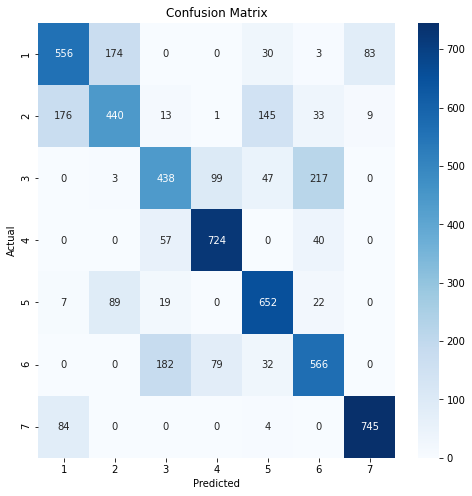

In [141]:
evaluate_model(logreg2, X_test, y_test)

### Naive Bayes

In [142]:
nb_param_grid = {"var_smoothing": np.logspace(0,-9, num=100)}

In [143]:
# n_iter value should be smaller or equal to the multiplied value of all parameters

rs_nb = RandomizedSearchCV(GaussianNB(), nb_param_grid, n_iter=50,
                               cv=5, verbose=1, random_state=0)
rs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=50,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.5111917...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=0, verbose=1)

In [144]:
print("Test set score: %.2f" % rs_nb.score(X_test, y_test))
print("Best cross-validation score: %.2f" % rs_nb.best_score_)
print("Best parameters:", rs_nb.best_params_)
print("Best estimator:", rs_nb.best_estimator_)

Test set score: 0.66
Best cross-validation score: 0.65
Best parameters: {'var_smoothing': 0.0657933224657568}
Best estimator: GaussianNB(var_smoothing=0.0657933224657568)


In [145]:
%%time

nb2 = GaussianNB(var_smoothing=0.0657933224657568)
nb2.fit(X_train, y_train)

CPU times: user 20.2 ms, sys: 1.61 ms, total: 21.8 ms
Wall time: 21.8 ms


GaussianNB(var_smoothing=0.0657933224657568)

Accuracy: 0.66
              precision    recall  f1-score   support

           1       0.61      0.63      0.62       846
           2       0.57      0.41      0.48       817
           3       0.61      0.49      0.54       804
           4       0.70      0.94      0.80       821
           5       0.61      0.74      0.67       789
           6       0.65      0.56      0.60       859
           7       0.81      0.87      0.84       833

    accuracy                           0.66      5769
   macro avg       0.65      0.66      0.65      5769
weighted avg       0.65      0.66      0.65      5769



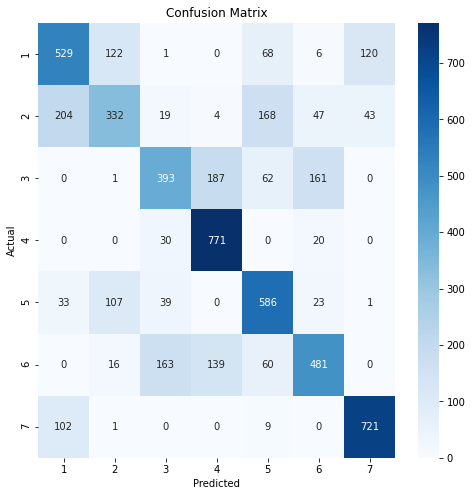

In [146]:
evaluate_model(nb2, X_test, y_test)

### Decision Tree Classifier

In [153]:
# Prefer dual=False when n_samples > n_features

svc_param_grid = {"dual": [True, False], 
                  "C": [10, 1, 0.1, 0.01]}

dt_param_grid = {
    "max_depth": [5, 10, 20, 50],
    "min_samples_leaf": [5, 10, 20, 50],
    "max_features": [None, "sqrt", "log2"]
}

In [154]:
# n_iter value should be smaller or equal to the multiplied value of all parameters

rs_dt = RandomizedSearchCV(DecisionTreeClassifier(), dt_param_grid, n_iter=50,
                               cv=5, verbose=1, random_state=0)
rs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   param_distributions={'max_depth': [2, 5, 10, 20, 50],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10, 20, 50]},
                   random_state=0, verbose=1)

In [155]:
print("Test set score: %.2f" % rs_dt.score(X_test, y_test))
print("Best cross-validation score: %.2f" % rs_dt.best_score_)
print("Best parameters:", rs_dt.best_params_)
print("Best estimator:", rs_dt.best_estimator_)

Test set score: 0.78
Best cross-validation score: 0.77
Best parameters: {'min_samples_leaf': 5, 'max_features': None, 'max_depth': 20}
Best estimator: DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)


In [156]:
%%time

dt1 = DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, max_features=None)
dt1.fit(X_train, y_train)

CPU times: user 161 ms, sys: 1.27 ms, total: 162 ms
Wall time: 161 ms


DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)

Accuracy: 0.78
              precision    recall  f1-score   support

           1       0.67      0.65      0.66       846
           2       0.61      0.60      0.60       817
           3       0.77      0.76      0.76       804
           4       0.89      0.94      0.92       821
           5       0.81      0.88      0.84       789
           6       0.79      0.76      0.77       859
           7       0.91      0.90      0.90       833

    accuracy                           0.78      5769
   macro avg       0.78      0.78      0.78      5769
weighted avg       0.78      0.78      0.78      5769



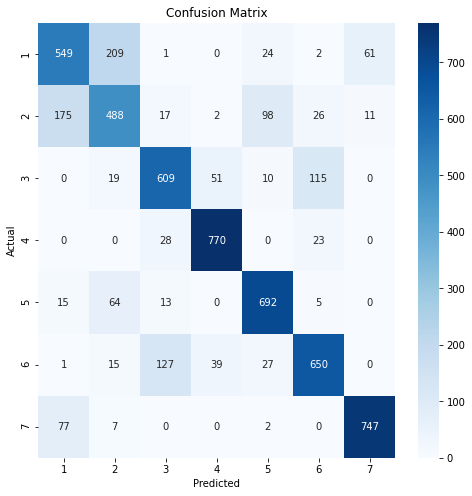

In [157]:
evaluate_model(dt1, X_test, y_test)

### Random Forest Classifier

In [167]:
rf_param_grid = {"bootstrap": [True], # if False, model will use all 1.9M data
              "max_depth": [5, 10, 20, 50], 
              "max_features": ["sqrt", "log2"],
              "n_estimators": [100, 200, 300]}

In [168]:
# n_iter value should be smaller or equal to the multiplied value of all parameters

rs_rf = RandomizedSearchCV(RandomForestClassifier(), rf_param_grid, n_iter=50,
                               cv=5, verbose=1, n_jobs=-1, random_state=0)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 200, 300]},
                   random_state=0, verbose=1)

In [169]:
print("Test set score: %.2f" % rs_rf.score(X_test, y_test))
print("Best cross-validation score: %.2f" % rs_rf.best_score_)
print("Best parameters:", rs_rf.best_params_)
print("Best estimator:", rs_rf.best_estimator_)

Test set score: 0.87
Best cross-validation score: 0.86
Best parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
Best estimator: RandomForestClassifier(max_depth=50, max_features='sqrt', n_estimators=200)


In [171]:
%%time

rf1 = RandomForestClassifier(bootstrap=True, max_features="sqrt", n_estimators=200, max_depth=50)
rf1.fit(X_train, y_train)

CPU times: user 4.91 s, sys: 77.6 ms, total: 4.98 s
Wall time: 4.98 s


RandomForestClassifier(max_depth=50, max_features='sqrt', n_estimators=200)

Accuracy: 0.87
              precision    recall  f1-score   support

           1       0.82      0.76      0.79       846
           2       0.77      0.70      0.73       817
           3       0.87      0.85      0.86       804
           4       0.92      0.98      0.95       821
           5       0.89      0.96      0.92       789
           6       0.87      0.87      0.87       859
           7       0.94      0.97      0.96       833

    accuracy                           0.87      5769
   macro avg       0.87      0.87      0.87      5769
weighted avg       0.87      0.87      0.87      5769



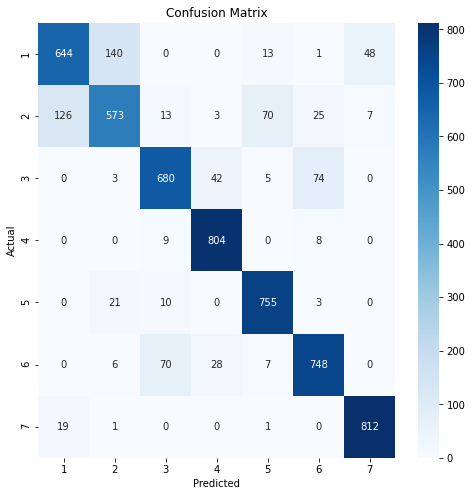

In [172]:
evaluate_model(rf1, X_test, y_test)

## Conclusion
**Imbalanced Data**

The performance of untuned models in an unbalanced data differs per algorithm. Logistic Regression suffers from long training time but can able to provide good accuracy. Meanwhile in the case of Naive Bayes, a classification model known for its speed in processing large datasets, the model outputs a very low accuracy score. However, basing how good a classification model is with accuracy score only is not a good approach, hence confusion matrix is used. The heatmap provides a good visualization of the confusion matrix of all classes. Here, we can see that although the Logistic Regression achieved an accuracy of 0.72, almost all of the data points are misclassified and only classes 1 and 2 performed well in predicting the true positives. Also, notice that classes 1 and 2 have the highest number of distribution. In the case of Naive Bayes, most of the classes are misclassified. Here, the imbalancing of the data did affect the performance of the models in evaluation. This concludes that a model with high accuracy score is not always a good model.

Disclaimer: Due to hardware limitations, Decision Tree and Random Forest Classifiers are not used.

| Model                | Training Time | Score |
|:---------------------|:-------------:|:-----:|
| Logistic Regression  | 1min 41s      |  0.72 |
| Naive Bayes          | 540ms         |  0.09 |
| Decision Tree        | N/A           |  N/A  |
| Random Forest        | N/A           |  N/A  |


**Undersampled Data**

After undersampling the data and tuning the hyperparameters of each model, the Naive Bayes performed well drastically. Although the accuracy score of the Logistic Regression fitted with undersampled data is slighly lower than that of the model fitted with imbalanced data, notice that most of the true positives are classified more accurately. The Decision Tree and Random Forest Classifiers also produced a high accuracy scores of 0.78 and 0.87, respectively. In their confusion matrices, most of the data points are classified accurately. Because of its high metric scores and good classification report, the Random Forest Classifier is the best suited model for this dataset.

| Model                | Training Time | Score |
|:---------------------|:-------------:|:-----:|
| Logistic Regression  | 27.6s         |  0.71 |
| Naive Bayes          | 21.8ms        |  0.66 |
| Decision Tree        | 162ms         |  0.78 |
| Random Forest        | 4.98s         |  0.87 |


For more classification model measure, precision, recall, and f-1 score of each class are provided in every classification report of each model. These evaluation metrics reflect how good a classification model is in detail compared to accuracy score.


### Recommendation

Because of the limitations in hardware components, some approach like using tree and ensemble classifiers in the imbalanced dataset and feeding the models with oversampled data is not practised. The output of this approach would have helped to differentiate the output of the models fitted with oversampled data and models fitted with undersampled data.

In case of oversampling the dataset, the following codeblock should be used:

```
# Oversampling

oversampled_raw = data.copy()

max_class_size = np.max(oversampled_raw["Cover_Type"].value_counts().values)

class_subsets = [oversampled_raw.query("Cover_Type == "+ str(i+1)) for i in range(7)]

for i in range(7):
    class_subsets[i] = class_subsets[i].sample(max_class_size, replace=True, random_state=0)
    
oversampled_data = pd.concat(class_subsets, axis=0).sample(frac=1.0, random_state=0)
oversampled_data = oversampled_data.reset_index(drop=True)
```

### References
https://archive.ics.uci.edu/ml/datasets/Covertype

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://www.kaggle.com/gcdatkin/forest-cover-type-prediction-class-imbalance